<a href="https://colab.research.google.com/github/ValentinoMalakianno/Pembelajaran_Mesin2023/blob/main/Jobsheet10_MachineLearning_ValentinoMalakianno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Valentino Malakianno Putra Nasima**
###3**G**
###**2141720099**
###**Link Github :**

**Job Sheet 10 : Recurrent Neural Network (RNN)**

RNN untuk Analisis Sentimen

Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"If you are under the age of 6 or 7, then you're going to really enjoy this movie. My youngest daughter is glued to the TV when she watches it. As an adult, I can't stand it!! I'm all up for sequels....when they have a decent storyline. But this is nowhere near up to standard. Please forgive me for slating what is after all a kid's film, but when you have to sit through it nearly every day when your kids who love it so much, you'll understand why. My daughter would watch this film over and over again on the same day if we let her.<br /><br />I've given this film 4 out of 10 purely for the fact that it keeps my youngest entertained."
 b'Marvelous cult film from 1979 in which the students of Vince Lombardi High School are confronted with a new, dictatorial principal named Miss Togar (Mary Woronov). Togar is a music hater and blames the musical tastes of the students for their transgressions. Leading the charge against her is fun-loving Riff Randell (P.J. Soles), the #1 Ramones 

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[45, 23, 24, ...,  0,  0,  0],
       [ 1,  1, 20, ...,  0,  0,  0],
       [11, 20,  7, ...,  0,  0,  0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu: -Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation". -Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"If you are under the age of 6 or 7, then you're going to really enjoy this movie. My youngest daughter is glued to the TV when she watches it. As an adult, I can't stand it!! I'm all up for sequels....when they have a decent storyline. But this is nowhere near up to standard. Please forgive me for slating what is after all a kid's film, but when you have to sit through it nearly every day when your kids who love it so much, you'll understand why. My daughter would watch this film over and over again on the same day if we let her.<br /><br />I've given this film 4 out of 10 purely for the fact that it keeps my youngest entertained."
Round-trip:  if you are under the age of [UNK] or [UNK] then youre going to really enjoy this movie my [UNK] daughter is [UNK] to the tv when she [UNK] it as an [UNK] i cant stand it im all up for [UNK] they have a decent storyline but this is [UNK] near up to [UNK] please [UNK] me for [UNK] what is after all a kids film but when you have to sit

**Buat Model**

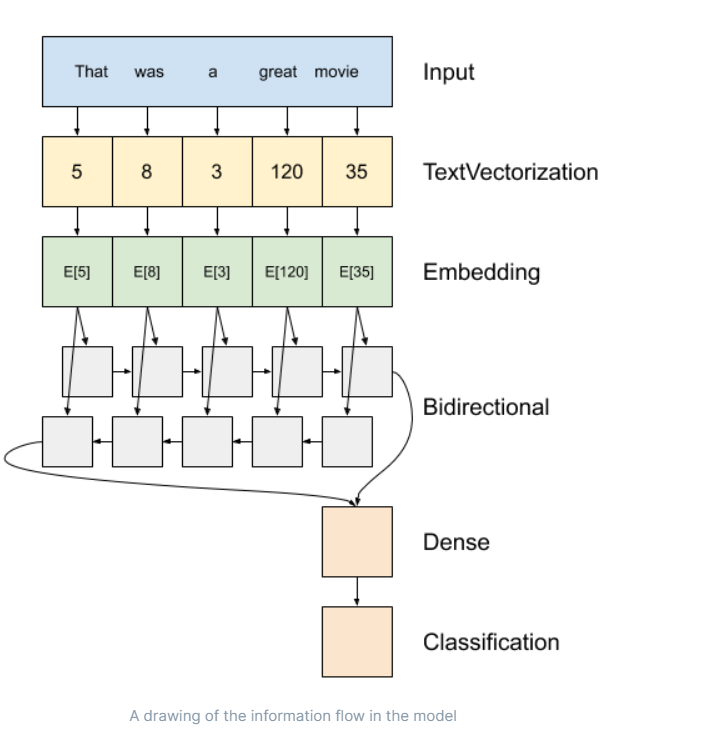

diagram model dapat dilihat pada gambar diatas

Model ini dapat dibuat sebagai tf.keras.Sequential.
Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

-**Keuntungan utama RNN dua arah** adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

-**Kerugian utama dari RNN dua arah** adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir. 5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.0015823]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 319ms/step
[0.0015823]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [6]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

NameError: ignored

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

NameError: ignored

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.